In [2]:
%load_ext autoreload
%autoreload 2
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs
import matplotlib.pyplot as plt
import torch

import neural_metric
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
import numpy as np
import torch.nn.functional as F
import main_eval 
import default_config

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using pytorch backend


# Evaluate Synthetic Data

### From analytic form of immersion

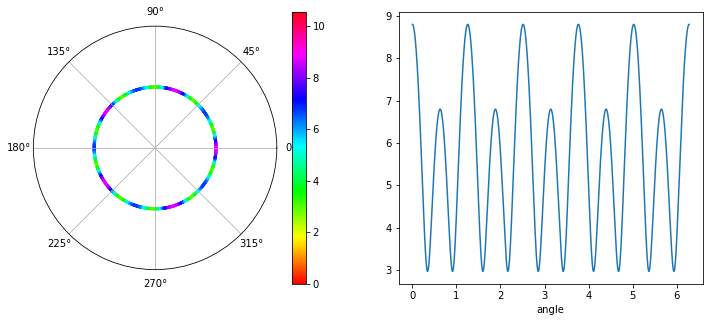

In [54]:
angles = gs.linspace(0,2*gs.pi,1000)

params = {
    "immersion_type": "analytic",
    "radius": 1,
    "n_wiggles": 5,
    "amp_wiggles": 0.3,
    "embedding_dim": 5,
    "model_filename": None,
    "rot": SpecialOrthogonal(n=5).random_point()
}


mean_curv_vectors = main_eval.mean_curv_vector(angles,params)

mean_curv_norms = [gs.linalg.norm(vec) for vec in mean_curv_vectors]

main_eval.plot(angles,mean_curv_norms)

## Learned immersion via VAE

### Load model

In [182]:
model_filename = "/Users/franciscoacosta/Desktop/code/abn/abn/results/trained_models/experimental_2022-09-07 17:09:00_model.pt"

model = torch.load(model_filename)


# from models.spherical_vae import SphericalVAE
# model1 = SphericalVAE(input_dim=6,
#                      encoder_dims=[40,40,40,40,40],
#                      latent_dim=2,
#                      distribution="vmf")

# model1.load_state_dict(torch.load("/Users/franciscoacosta/Desktop/code/abn/abn/results/modelsd.pt"))

# model1.eval()

### Compare reconstruction with inputs

Dataset shape: torch.Size([1000, 4]).


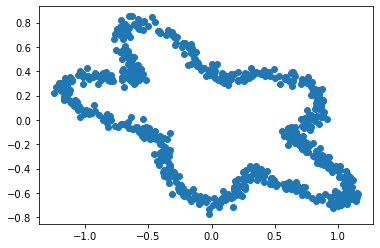

In [174]:
from datasets import utils
dataset_torch, labels, train_loader, test_loader = datasets.utils.load(default_config)

x = [train_loader.dataset[i][0][0] for i in range(700)]
y = [train_loader.dataset[i][0][1] for i in range(700)]

plt.scatter(x,y)

In [183]:
thetas = torch.linspace(0,2*torch.pi,1000)
z = torch.stack([torch.cos(thetas), torch.sin(thetas)],axis=-1)

rec = model.decode(z)

torch.Size([1000, 40])

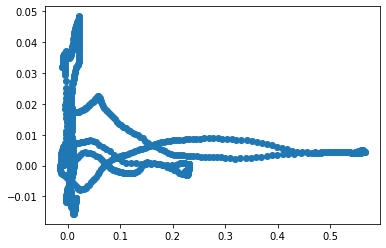

In [186]:
x_rec = rec[0][:,0].cpu().detach().numpy()
y_rec = rec[0][:,1].cpu().detach().numpy()

plt.scatter(x_rec,y_rec)

In [191]:
from datasets.synthetic import load_wiggles

from datasets.experimental import load_place_cells

# dataset, labels = load_wiggles(default_config.rot,
#     n_times=default_config.n_times,
#     synth_radius=default_config.synth_radius,
#     n_wiggles=default_config.n_wiggles,
#     amp_wiggles=default_config.amp_wiggles,
#     embedding_dim=default_config.embedding_dim,
#     noise_var=default_config.noise_var)

dataset, labels = load_place_cells(
    expt_id=default_config.expt_id, timestep_microsec=default_config.timestep_microsec
)
print(labels)

dataset = dataset[labels["velocities"] > 1]
labels = labels[labels["velocities"] > 1]
dataset = np.log(dataset.astype(np.float32) + 1)
# dataset = dataset[:, :-2]  # last column is weird
dataset = (dataset - np.min(dataset)) / (np.max(dataset) - np.min(dataset))

dataset = torch.tensor(dataset)
_, posterior_params = model(dataset)


INFO: # - Found file at data/expt34_times_timestep1000000.txt! Loading...
INFO: # - Found file at data/expt34_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at data/expt34_labels_timestep1000000.txt! Loading...
/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


      Unnamed: 0         times      angles  velocities  gains
0              0  3.625397e+08  125.815085   -0.104195    1.0
1              1  3.635397e+08  129.515412   13.455259    1.0
2              2  3.645397e+08  154.552048   30.988614    1.0
3              3  3.655397e+08  184.048601   27.353089    1.0
4              4  3.665397e+08  212.071814   28.240268    1.0
...          ...           ...         ...         ...    ...
2948        2948  3.310540e+09   37.660339    0.094720    1.0
2949        2949  3.311540e+09   38.190007    1.087265    1.0
2950        2950  3.312540e+09   38.595808   -1.100449    1.0
2951        2951  3.313540e+09   46.685671   16.660279    1.0
2952        2952  3.314540e+09   54.966355    1.060331    1.0

[2953 rows x 5 columns]


In [192]:
z = model.reparameterize(posterior_params)[0]

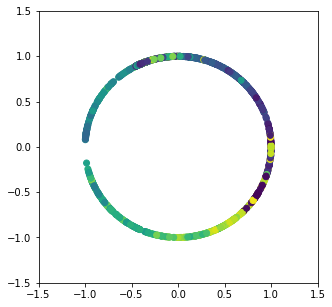

In [193]:
plt.figure(figsize=(5,5))
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

z0 = z[:,0].cpu().detach().numpy()
z1 = z[:,1].cpu().detach().numpy()

plt.scatter(z0,z1,c=labels["angles"])

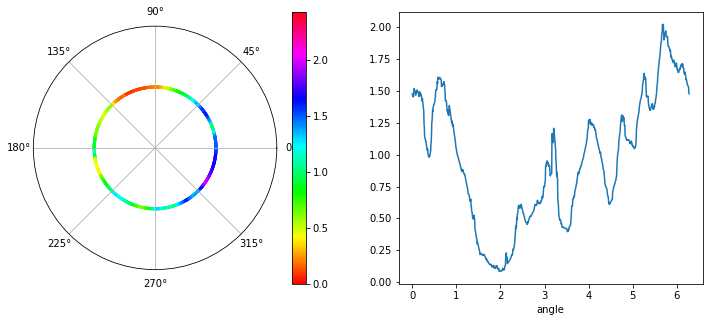

In [188]:
params = {
    "immersion_type": "VAE",
    "radius": None,
    "n_wiggles": None,
    "amp_wiggles": None,
    "embedding_dim": 40,
    "model": model,
}

angles = gs.linspace(0,2*gs.pi,1000)

mean_curv_vectors = main_eval.mean_curv_vector(angles,params)

mean_curv_norm = [gs.linalg.norm(vec) for vec in mean_curv_vectors]

main_eval.plot(angles,mean_curv_norm)